In [7]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

In [8]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [10]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [ ]:
# from a dropsown list above we choose model-txt2img-stabilityai-stable-diffusion-v2-1-base

In [12]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

In [13]:
print(model_id)

model-txt2img-stabilityai-stable-diffusion-v2-1-base


In [14]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=model_id,
    model_version=model_version,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type='ml.g5.2xlarge',
)

In [15]:
model_uri = 's3://sagemaker-zara-blouses-generation/loading_dataset/model/model.tar.gz'

In [16]:
# To increase the maximum response size (in bytes) from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# Deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.g5.2xlarge',
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

-------!

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

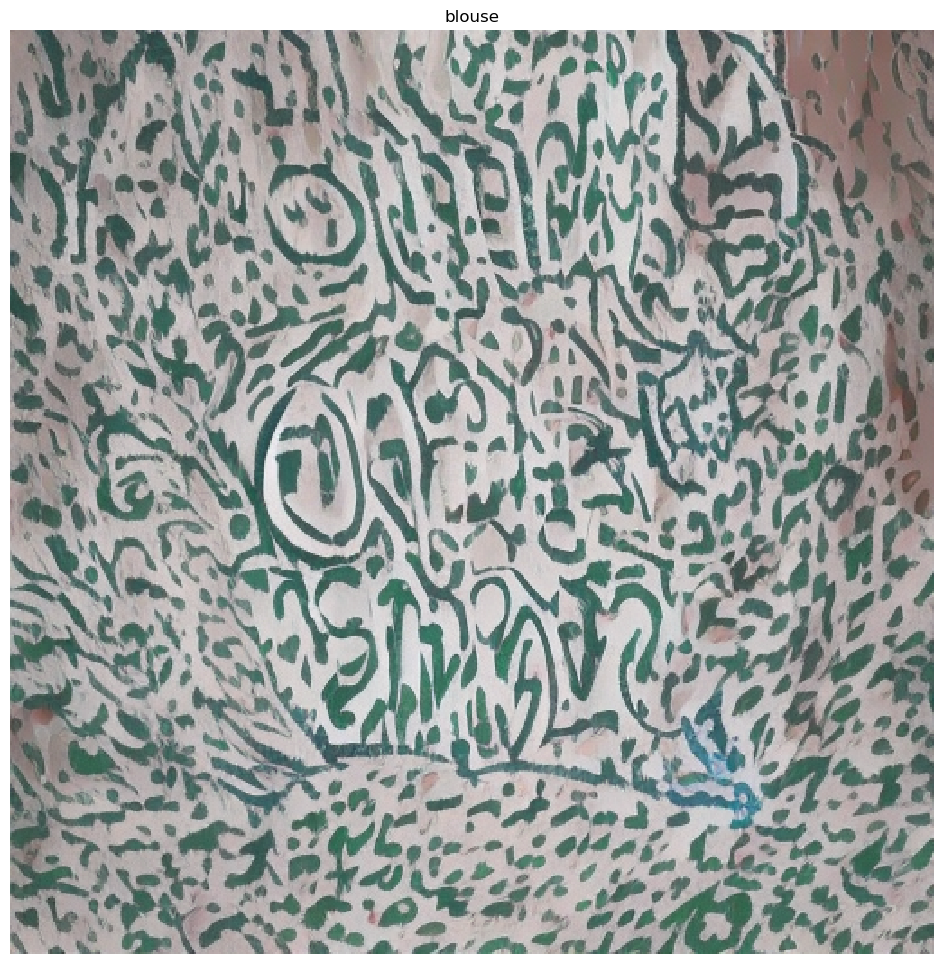

In [18]:
text = "blouse"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)